<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
pip install torch

     -------------------------------------- 172.4/172.4 MB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 6.5/6.5 MB 4.1 MB/s eta 0:00:00
     -------------------------------------- 536.2/536.2 KB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\vbadmaev1\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [55]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

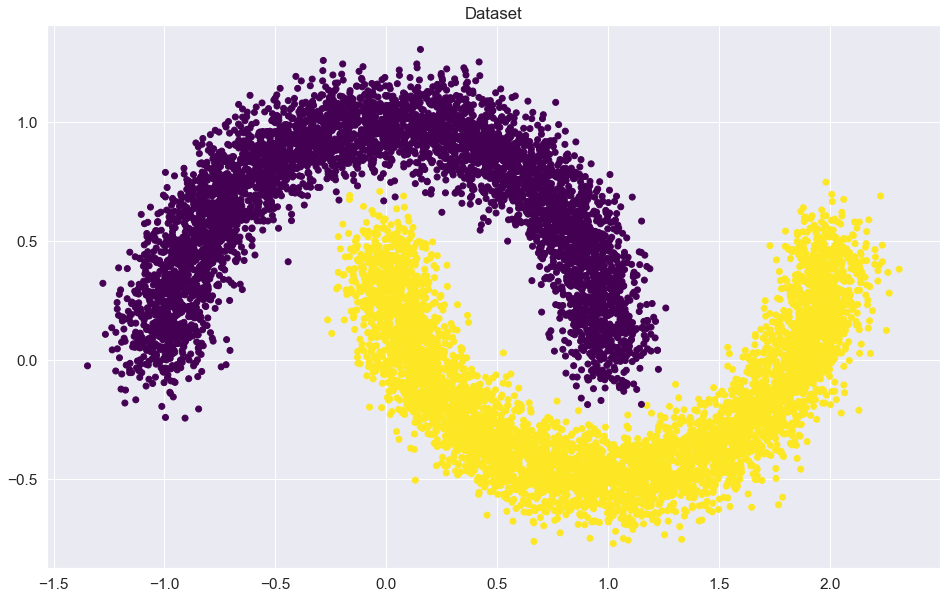

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [9]:
linear_regression = LinearRegression(2,1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.1894],
         [1.1918]], requires_grad=True),
 Parameter containing:
 tensor([-0.8189], requires_grad=True)]

Обучаемых параметров: 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.2734375
Iteration: 100
Batch accuracy: 0.6015625
Iteration: 200
Batch accuracy: 0.7578125
Iteration: 300
Batch accuracy: 0.8125
Iteration: 400
Batch accuracy: 0.78125
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8125

Iteration: 932.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 932

### Визуализируем результаты

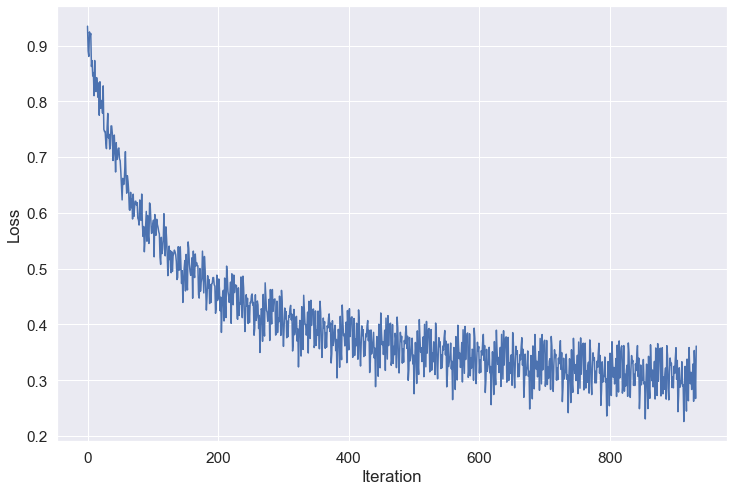

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

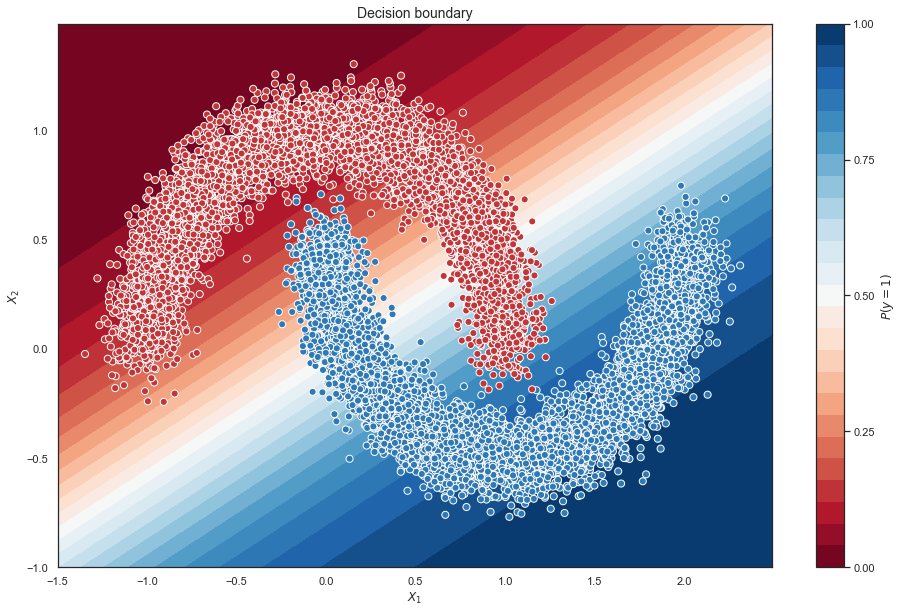

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

y_predict = predict(val_dataloader, linear_regression)
accuracy_score(y_val, y_predict)

0.8572

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8572

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [41]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.Collecting torchvision
     ---------------------------------------- 1.2/1.2 MB 197.1 kB/s eta 0:00:00



You should consider upgrading via the 'c:\users\vbadmaev1\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [56]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=100, shuffle=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [67]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [23]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = torch.softmax(model(x_batch), dim=1)
                 
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8907166666666667
Loader: valid. Accuracy: 0.9355
Epoch: 2
Loader: train. Accuracy: 0.9524333333333334
Loader: valid. Accuracy: 0.9593
Epoch: 3
Loader: train. Accuracy: 0.9650666666666666
Loader: valid. Accuracy: 0.9666
Epoch: 4
Loader: train. Accuracy: 0.9710333333333333
Loader: valid. Accuracy: 0.9696
Epoch: 5
Loader: train. Accuracy: 0.9760166666666666
Loader: valid. Accuracy: 0.9721
Epoch: 6
Loader: train. Accuracy: 0.9793
Loader: valid. Accuracy: 0.9707
Epoch: 7
Loader: train. Accuracy: 0.98175
Loader: valid. Accuracy: 0.973
Epoch: 8
Loader: train. Accuracy: 0.9843833333333334
Loader: valid. Accuracy: 0.9699
Epoch: 9
Loader: train. Accuracy: 0.9855
Loader: valid. Accuracy: 0.9739
Epoch: 10
Loader: train. Accuracy: 0.9869666666666667
Loader: valid. Accuracy: 0.9742


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [70]:
elu_accuracy = accuracy["valid"]

In [64]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    activation = activation

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                      outp = torch.softmax(model(x_batch), dim=1)
                    
                preds = outp.argmax(-1)
                correct =  (preds == y_batch).sum()
                all =  len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [68]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8730666666666667
Loader: valid. Accuracy: 0.9012
Epoch: 2
Loader: train. Accuracy: 0.8998166666666667
Loader: valid. Accuracy: 0.9097
Epoch: 3
Loader: train. Accuracy: 0.9079166666666667
Loader: valid. Accuracy: 0.9041
Epoch: 4
Loader: train. Accuracy: 0.9083
Loader: valid. Accuracy: 0.9098
Epoch: 5
Loader: train. Accuracy: 0.9109333333333334
Loader: valid. Accuracy: 0.908
Epoch: 6
Loader: train. Accuracy: 0.91335
Loader: valid. Accuracy: 0.9174
Epoch: 7
Loader: train. Accuracy: 0.9117833333333333
Loader: valid. Accuracy: 0.9044
Epoch: 8
Loader: train. Accuracy: 0.9127166666666666
Loader: valid. Accuracy: 0.9122
Epoch: 9
Loader: train. Accuracy: 0.9150166666666667
Loader: valid. Accuracy: 0.9133
Epoch: 10
Loader: train. Accuracy: 0.9152166666666667
Loader: valid. Accuracy: 0.9086
Epoch: 1
Loader: train. Accuracy: 0.8820666666666667
Loader: valid. Accuracy: 0.9293
Epoch: 2
Loader: train. Accuracy: 0.9444
Loader: valid. Accuracy: 0.9533
Epoch: 3
Loader

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

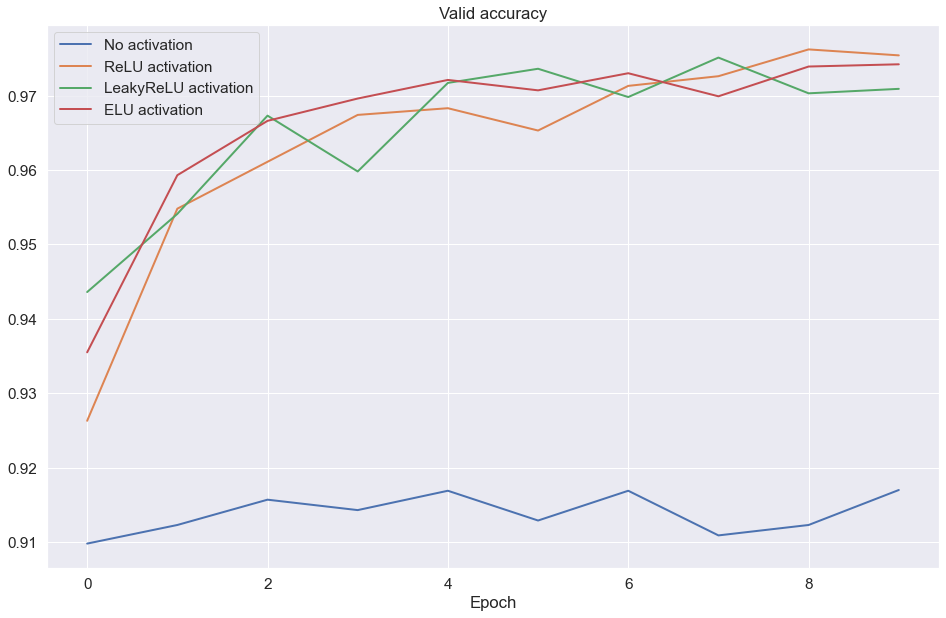

In [27]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

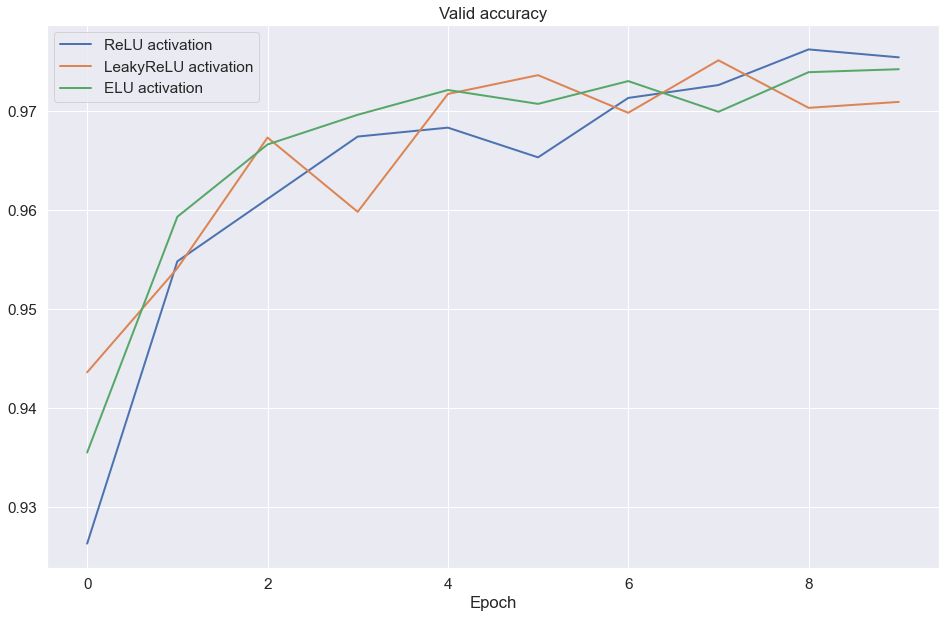

In [28]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [34]:
pip install wget

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=e86c3cc2116a359e9cffd07643a42d5a0233fb685848d37cf087465e877a0a6e
  Stored in directory: c:\users\vbadmaev1\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [38]:
import wget

In [39]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [43]:
import wget

url = 'https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg'
filename = 'sample_photo.jpg'

wget.download(url, filename)

HTTPError: HTTP Error 403: Forbidden

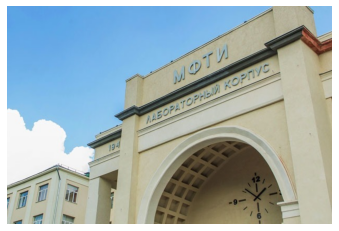

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('sample_photo.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
pip install sns

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2643 sha256=2bdb84c522f7b7e9b5bf8bb78a4817a68ac010188eb2d2520aec506aa206251f
  Stored in directory: c:\users\vbadmaev1\appdata\local\pip\cache\wheels\ff\12\fa\4d724fdfed493cfe12b239ae9a0bc26b2fd85bb7dc9ecde7c3
Successfully built sns
Note: you may need to restart the kernel to use updated packages.


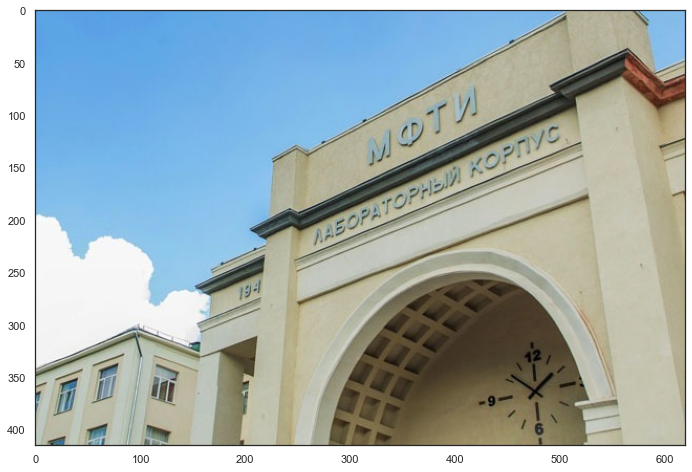

In [45]:
import cv2
import seaborn as sns
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

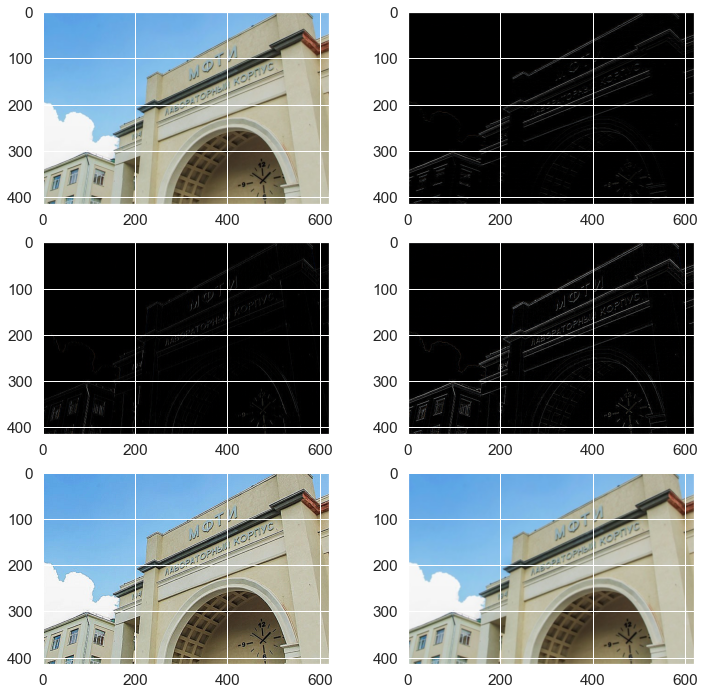

In [51]:
kernels = np.array([
    np.array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]], np.float32),
    np.array([[0, 1, 0],
              [0, -2, 0],
              [0, 1, 0]], np.float32),
    np.array([[0, 0, 0],
              [1, -2, 1],
              [0, 0, 0]], np.float32),
    np.array([[0, 1, 0],
              [1, -4, 1],
              [0, 1, 0]], np.float32),
    np.array([[0, -1, 0],
              [-1, 5, -1],
              [0, -1, 0]], np.float32),
    np.array([[0.0625, 0.125, 0.0625],
              [0.125, 0.25, 0.125],
              [0.0625, 0.125, 0.0625]], np.float32)
])

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for kernel, ax in zip(kernels, axs.flatten()):
    ax.imshow(cv2.filter2D(src=RGB_img, kernel=kernel, ddepth=-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


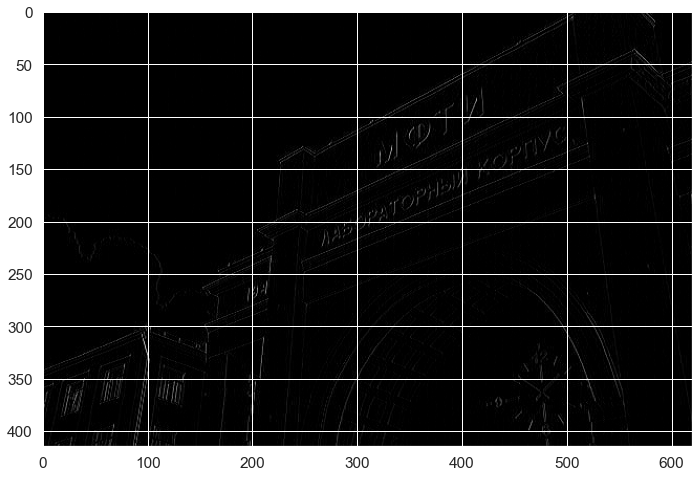

In [52]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1-Е, 2-Д, 3-А, 4-В, 5-Б, 6-Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [53]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
     

In [59]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [60]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = torch.softmax(model(x_batch), dim=1)
                 
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8988
Loader: valid. Accuracy: 0.9714
Epoch: 2
Loader: train. Accuracy: 0.9720833333333333
Loader: valid. Accuracy: 0.979
Epoch: 3
Loader: train. Accuracy: 0.98115
Loader: valid. Accuracy: 0.9837
Epoch: 4
Loader: train. Accuracy: 0.9841
Loader: valid. Accuracy: 0.9842
Epoch: 5
Loader: train. Accuracy: 0.9873166666666666
Loader: valid. Accuracy: 0.9848
Epoch: 6
Loader: train. Accuracy: 0.98945
Loader: valid. Accuracy: 0.9895
Epoch: 7
Loader: train. Accuracy: 0.9909166666666667
Loader: valid. Accuracy: 0.9883
Epoch: 8
Loader: train. Accuracy: 0.99175
Loader: valid. Accuracy: 0.9884
Epoch: 9
Loader: train. Accuracy: 0.9930166666666667
Loader: valid. Accuracy: 0.99
Epoch: 10
Loader: train. Accuracy: 0.9941
Loader: valid. Accuracy: 0.9882


In [61]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

Epoch: 1
Loader: train. Accuracy: 0.88365
Loader: valid. Accuracy: 0.9335
Epoch: 2
Loader: train. Accuracy: 0.9454333333333333
Loader: valid. Accuracy: 0.9561
Epoch: 3
Loader: train. Accuracy: 0.9590833333333333
Loader: valid. Accuracy: 0.9616
Epoch: 4
Loader: train. Accuracy: 0.96845
Loader: valid. Accuracy: 0.9654
Epoch: 5
Loader: train. Accuracy: 0.97185
Loader: valid. Accuracy: 0.9643
Epoch: 6
Loader: train. Accuracy: 0.9753333333333334
Loader: valid. Accuracy: 0.9718
Epoch: 7
Loader: train. Accuracy: 0.9793166666666666
Loader: valid. Accuracy: 0.9734
Epoch: 8
Loader: train. Accuracy: 0.9811333333333333
Loader: valid. Accuracy: 0.9708
Epoch: 9
Loader: train. Accuracy: 0.9823
Loader: valid. Accuracy: 0.9719
Epoch: 10
Loader: train. Accuracy: 0.9843
Loader: valid. Accuracy: 0.9753


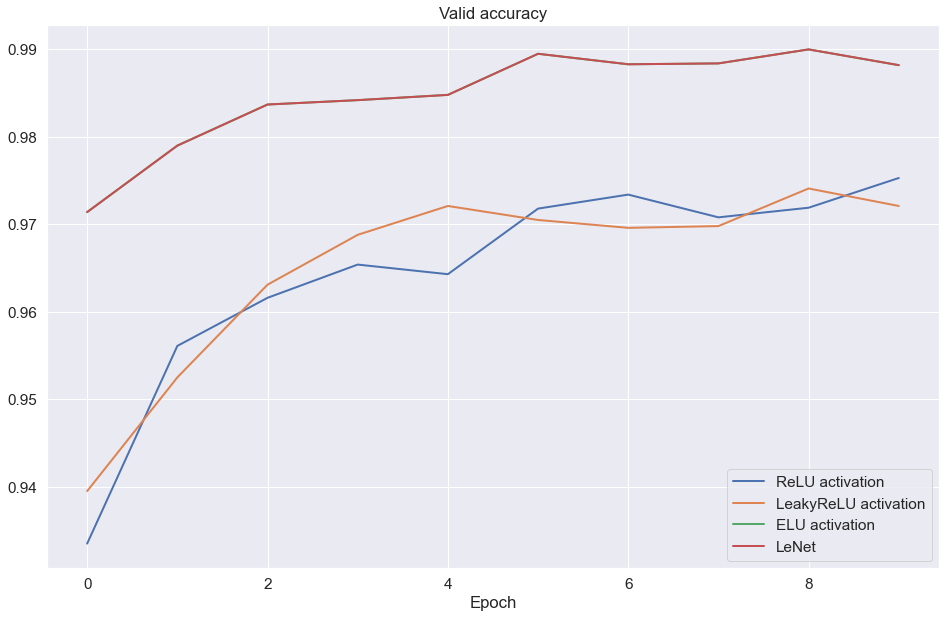

In [71]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
relu_accuracy = test_activation_function(nn.ReLU)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99